In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize

In [ ]:
from keras.applications.vgg19 import VGG19

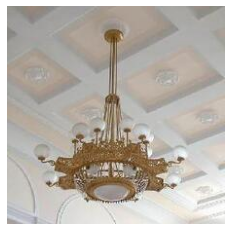

In [176]:
path = '/Users/rajeshr/Desktop/Group_22/fewimages/chandelier3.jpg'
imgage = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
img =  tf.keras.preprocessing.image.img_to_array(image)
x = np.expand_dims(img, axis=0)
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(x)

In [177]:
model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=True)

In [178]:
layername='block5_conv4'

gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(LAYER_NAME).output])
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu
        
with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)[0]
grads = tape.gradient(outputs,inputs)[0]

In [182]:
weights = tf.reduce_mean(grads, axis=(0, 1))
grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
for i, w in enumerate(weights):
    grad_cam += w * outputs[:, :, i]

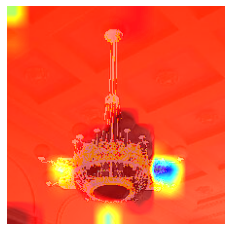

In [183]:
grad_cam_img = cv2.resize(grad_cam.numpy(), (224, 224))
grad_cam_img = np.maximum(grad_cam_img, 0)
heatmap = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
grad_cam_img = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, grad_cam_img, 1, 0)

plt.imshow(output_image)
plt.axis("off")
plt.savefig('/Users/rajeshr/Desktop/heatmaps'+str(np.random.randint(1000))+'.png')
plt.show()

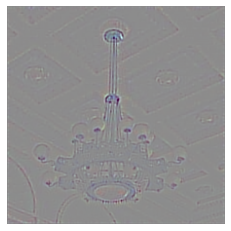

In [187]:
guided_back_prop =grads
gb_viz = np.dstack((
            guided_back_prop[:, :, 0],
            guided_back_prop[:, :, 1],
            guided_back_prop[:, :, 2],
        ))       
gb_viz -= np.min(gb_viz)
gb_viz /= gb_viz.max()
imgplot = plt.imshow(gb_viz)
plt.axis("off")
plt.savefig('/Users/rajeshr/Desktop/guidedbackprop'+str(np.random.randint(1000))+'.png')
plt.show()